In [1]:
# pip install pulp

In [2]:
import pulp
from pulp import *

import numpy as np
import pandas as pd

import datetime
import matplotlib.pyplot as plt

## Load Data

In [3]:
file_path = 'CSV_Files_Food_Delivery/'

In [4]:
df_distances = pd.read_csv(file_path + 'distances.csv')

df_ordersA = pd.read_csv(file_path + 'part1_ordersA.csv')
df_ordersB = pd.read_csv(file_path + 'part1_ordersB.csv')

In [5]:
df_distances.head()

,origin,destination,distance
0,Scarborough (Malvern / Rouge River),Scarborough (Rouge Hill / Port Union / Highlan...,3.931478
1,Scarborough (Malvern / Rouge River),Scarborough (Guildwood / Morningside / Ellesmere),4.864191
2,Scarborough (Malvern / Rouge River),Scarborough (Woburn),4.778347
3,Scarborough (Malvern / Rouge River),Scarborough (Cedarbrae),6.009861
4,Scarborough (Malvern / Rouge River),Scarborough (Eglinton),7.876162


In [6]:
df_ordersA

,restaurant,customer
0,Downtown Toronto (Underground city),Downtown Toronto (Central Bay Street)


In [7]:
df_ordersB

,restaurant,customer
0,Downtown Toronto (Central Bay Street),Downtown Toronto (Underground city)
1,Etobicoke Northwest (Clairville / Humberwood /...,Etobicoke (South Steeles / Silverstone / Humbe...
2,York (Cedarvale),Central Toronto (The Annex / North Midtown / Y...
3,Downtown Toronto (Central Bay Street),Downtown Toronto (Richmond / Adelaide / King)
4,Downtown Toronto (Richmond / Adelaide / King),Downtown Toronto (St. James Town / Cabbagetown)


# Part I

## Sets

In [8]:
starting_location = 'Downtown Toronto (Rosedale)'

In [9]:
df = df_ordersB

In [10]:
# Get start and end locations
start_locations = list(df['restaurant'].unique()) + list(df['customer'].unique())
end_locations = start_locations.copy()

start_locations = list(dict.fromkeys(start_locations))
end_locations = list(dict.fromkeys(end_locations))

if starting_location in start_locations:
    start_locations.remove(starting_location)
    start_locations.append(starting_location)
else:
    start_locations.append(starting_location)

In [11]:
# Get unique Restraurants and Customers
restaurants = df['restaurant'].unique().tolist()
customers = df['customer'].unique().tolist()

In [12]:
num_steps = np.arange(1, len(end_locations)+1).tolist()

In [13]:
end_locations

['Downtown Toronto (Central Bay Street)',
 'Etobicoke Northwest (Clairville / Humberwood / Woodbine Downs / West Humber / Kipling Heights / Rexdale / Elms / Tandridge / Old Rexdale)',
 'York (Cedarvale)',
 'Downtown Toronto (Richmond / Adelaide / King)',
 'Downtown Toronto (Underground city)',
 'Etobicoke (South Steeles / Silverstone / Humbergate / Jamestown / Mount Olive / Beaumond Heights / Thistletown / Albion Gardens)',
 'Central Toronto (The Annex / North Midtown / Yorkville)',
 'Downtown Toronto (St. James Town / Cabbagetown)']

In [14]:
num_steps

[1, 2, 3, 4, 5, 6, 7, 8]

In [15]:
order_df = pd.DataFrame({'Restaurant':[], 'Customer':[]})

for index, row in df.iterrows():
    order_df.loc[index, 'Restaurant'] = row["restaurant"]
    order_df.loc[index, 'Customer'] = row["customer"]

order_df

,Restaurant,Customer
0,Downtown Toronto (Central Bay Street),Downtown Toronto (Underground city)
1,Etobicoke Northwest (Clairville / Humberwood /...,Etobicoke (South Steeles / Silverstone / Humbe...
2,York (Cedarvale),Central Toronto (The Annex / North Midtown / Y...
3,Downtown Toronto (Central Bay Street),Downtown Toronto (Richmond / Adelaide / King)
4,Downtown Toronto (Richmond / Adelaide / King),Downtown Toronto (St. James Town / Cabbagetown)


In [16]:
travel_df = pd.DataFrame({'Start':[], 'End': [], 'Distance': [], 'Time': []})


for i in start_locations:
    for j in end_locations: 
        if i == j:
            new_row_data = {'Start': i, 'End': j, 'Distance': 0, 'Time': np.nan}
            new_row = pd.DataFrame(new_row_data, index=[0])
            travel_df = pd.concat([travel_df, new_row], ignore_index=True)
        else:
            d_temp = float(df_distances[(df_distances['origin'] == i) & 
                                                          (df_distances['destination'] == j)]['distance'])
            new_row_data = {'Start': i, 'End': j, 'Distance': d_temp, 'Time': np.nan}
            new_row = pd.DataFrame(new_row_data, index=[0])
            travel_df = pd.concat([travel_df, new_row], ignore_index=True)

In [17]:
travel_df

,Start,End,Distance,Time
0,Downtown Toronto (Central Bay Street),Downtown Toronto (Central Bay Street),0.000000,NaN
1,Downtown Toronto (Central Bay Street),Etobicoke Northwest (Clairville / Humberwood /...,17.693277,NaN
2,Downtown Toronto (Central Bay Street),York (Cedarvale),5.306327,NaN
3,Downtown Toronto (Central Bay Street),Downtown Toronto (Richmond / Adelaide / King),0.786711,NaN
4,Downtown Toronto (Central Bay Street),Downtown Toronto (Underground city),0.854155,NaN
...,...,...,...,...
67,Downtown Toronto (Rosedale),Downtown Toronto (Richmond / Adelaide / King),3.772651,NaN
68,Downtown Toronto (Rosedale),Downtown Toronto (Underground city),3.799404,NaN
69,Downtown Toronto (Rosedale),Etobicoke (South Steeles / Silverstone / Humbe...,18.513552,NaN
70,Downtown Toronto (Rosedale),Central Toronto (The Annex / North Midtown / Y...,2.653323,NaN


## Model Setup

In [18]:
model = LpProblem(name = 'Part1_Model', sense = LpMinimize)

xVar = LpVariable.dict('x', (start_locations, end_locations, num_steps), cat = LpBinary)

In [19]:
obj = lpSum([travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Distance'].iloc[0] * xVar[(i,j,t)] \
             for i in start_locations for j in end_locations for t in num_steps])
model += obj

## Constraints

In [20]:
def restaurant_customer_match(customer, order_df):
    for index, row in order_df.iterrows():
        if customer == order_df.loc[index, 'Customer']:
            return order_df.loc[index, 'Restaurant']

In [21]:
# Every location receives order once
for j in end_locations: 
    model += lpSum([xVar[(i,j,t)] for i in start_locations for t in num_steps]) == 1

In [22]:
# Convervation of flow
for t in num_steps[:-1]:
    for j in end_locations:
        model += (lpSum([xVar[(i,j,t)] for i in start_locations]) == lpSum([xVar[(j,k,t+1)] for k in end_locations]))

In [23]:
# First node has an outflow of 1, others 0
model += lpSum([xVar[(start_locations[-1],j,1)] for j in restaurants]) == 1

for i in start_locations[:-1]:
    model += lpSum([xVar[(i,j,1)] for j in end_locations]) == 0

In [24]:
# Visit restaurant before customer
for t in num_steps: 
    for j in end_locations: 
        if j in customers: 
            model += pulp.lpSum( [xVar[i,j,t] for i in start_locations]) <= pulp.lpSum([xVar[i, restaurant_customer_match(j, order_df),t_] \
                                                                                        for i in start_locations \
                                                                                        for t_ in num_steps[:t]])

## Solve

In [25]:
# Solve the model
model.solve()
print("Status:", LpStatus[model.status])

Status: Optimal


In [26]:
# Total Distance
total_distance = pulp.value(model.objective)
print("Total Distance: " , total_distance)

Total Distance:  33.875942274546034


In [27]:
# Print the results
path=[]
for t in num_steps:
    print(f'step:{t}\n')
    for i in start_locations:
         for j in end_locations:
                if (xVar[(i,j,t)].varValue == 1) :
                    print(f"TRAVEL FROM {i}  TO {j}")
                    
                    if i not in path:
                        path.append(i)
                    if j not in path:
                        path.append(j)

step:1

TRAVEL FROM Downtown Toronto (Rosedale)  TO Downtown Toronto (Central Bay Street)
step:2

TRAVEL FROM Downtown Toronto (Central Bay Street)  TO Downtown Toronto (Richmond / Adelaide / King)
step:3

TRAVEL FROM Downtown Toronto (Richmond / Adelaide / King)  TO Downtown Toronto (Underground city)
step:4

TRAVEL FROM Downtown Toronto (Underground city)  TO Downtown Toronto (St. James Town / Cabbagetown)
step:5

TRAVEL FROM Downtown Toronto (St. James Town / Cabbagetown)  TO York (Cedarvale)
step:6

TRAVEL FROM York (Cedarvale)  TO Central Toronto (The Annex / North Midtown / Yorkville)
step:7

TRAVEL FROM Central Toronto (The Annex / North Midtown / Yorkville)  TO Etobicoke Northwest (Clairville / Humberwood / Woodbine Downs / West Humber / Kipling Heights / Rexdale / Elms / Tandridge / Old Rexdale)
step:8

TRAVEL FROM Etobicoke Northwest (Clairville / Humberwood / Woodbine Downs / West Humber / Kipling Heights / Rexdale / Elms / Tandridge / Old Rexdale)  TO Etobicoke (South Steel

# Part II

## Load Data

In [28]:
df_distances = pd.read_csv(file_path + 'distances.csv')

df_ordersA = pd.read_csv(file_path + 'part2_ordersA.csv')
df_ordersB = pd.read_csv(file_path + 'part2_ordersB.csv')

In [29]:
df_distances.head()

,origin,destination,distance
0,Scarborough (Malvern / Rouge River),Scarborough (Rouge Hill / Port Union / Highlan...,3.931478
1,Scarborough (Malvern / Rouge River),Scarborough (Guildwood / Morningside / Ellesmere),4.864191
2,Scarborough (Malvern / Rouge River),Scarborough (Woburn),4.778347
3,Scarborough (Malvern / Rouge River),Scarborough (Cedarbrae),6.009861
4,Scarborough (Malvern / Rouge River),Scarborough (Eglinton),7.876162


In [30]:
df_ordersA

,restaurant,customer,estimated availability
0,Scarborough (Kennedy Park / Ionview / East Bir...,Scarborough (Woburn),2022-04-02 7:27 PM
1,Central Toronto (North Toronto West),Etobicoke (Westmount),2022-04-02 8:30 PM


In [31]:
df_ordersB

,restaurant,customer,estimated availability
0,Etobicoke (Islington Avenue),Downtown Toronto Stn A PO Boxes 25 The Esplana...,2022-04-02 5:17 PM
1,North York (Sweeney Park / Wigmore Park),Downtown Toronto (University of Toronto / Harb...,2022-04-02 5:49 PM
2,Scarborough (The Golden Mile / Clairlea / Oakr...,Downtown Toronto (Rosedale),2022-04-02 6:17 PM
3,Etobicoke (Westmount),Etobicoke (West Deane Park / Princess Gardens ...,2022-04-02 5:53 PM


## Data Preparation

In [478]:
# Route A or B
route = 'B'

In [479]:
starting_location = 'Downtown Toronto (Rosedale)'
average_velocity = 40 # Km/Hr
average_wait = 5 # Mins

# Convert to Km/Min
velocity_min = average_velocity / 60

In [480]:
# Route variables
W = 50
test_W = range(0, 120, 5)

if route == 'A':
    print('Route A')
    df = df_ordersA
    start_time = pd.to_datetime('2022-04-02 19:00:00')
else:
    print('Route B')
    df = df_ordersB
    start_time = pd.to_datetime('2022-04-02 17:00:00')

Route B


In [481]:
# Get start and end locations
start_locations = list(df['restaurant'].unique()) + list(df['customer'].unique())
end_locations = start_locations.copy()

start_locations = list(dict.fromkeys(start_locations))
end_locations = list(dict.fromkeys(end_locations))

if starting_location in start_locations:
    start_locations.remove(starting_location)
    start_locations.append(starting_location)
else:
    start_locations.append(starting_location)


In [482]:
order_locations = list(df['restaurant']) + list(df['customer'])
order_locations

['Etobicoke (Islington Avenue)',
 'North York (Sweeney Park / Wigmore Park)',
 'Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)',
 'Etobicoke (Westmount)',
 'Downtown Toronto Stn A PO Boxes 25 The Esplanade (Enclave of M5E)',
 'Downtown Toronto (University of Toronto / Harbord)',
 'Downtown Toronto (Rosedale)',
 'Etobicoke (West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale)']

In [483]:
# Calculate the number of stops 
num_steps = np.arange(1, len(end_locations)+1).tolist()

In [484]:
# Get unique Restraurants and Customers
restaurants = df['restaurant'].unique().tolist()
customers = df['customer'].unique().tolist()

In [485]:
order_df = pd.DataFrame({'Restaurant':[], 'Customer':[]})

for index, row in df.iterrows():
    order_df.loc[index, 'Restaurant'] = row["restaurant"]
    order_df.loc[index, 'Customer'] = row["customer"]

order_df

,Restaurant,Customer
0,Etobicoke (Islington Avenue),Downtown Toronto Stn A PO Boxes 25 The Esplana...
1,North York (Sweeney Park / Wigmore Park),Downtown Toronto (University of Toronto / Harb...
2,Scarborough (The Golden Mile / Clairlea / Oakr...,Downtown Toronto (Rosedale)
3,Etobicoke (Westmount),Etobicoke (West Deane Park / Princess Gardens ...


In [486]:
travel_df = pd.DataFrame({'Start':[], 'End': [], 'Distance': [], 'Time': []})


for i in start_locations:
    for j in end_locations: 
        if i == j:
            new_row_data = {'Start': i, 'End': j, 'Distance': 0, 'Time': 0}
            new_row = pd.DataFrame(new_row_data, index=[0])
            travel_df = pd.concat([travel_df, new_row], ignore_index=True)
        else:
            d_temp = float(df_distances[(df_distances['origin'] == i) & 
                                                          (df_distances['destination'] == j)]['distance'])
            t_temp = d_temp/average_velocity * 60
            new_row_data = {'Start': i, 'End': j, 'Distance': d_temp, 'Time': t_temp}
            new_row = pd.DataFrame(new_row_data, index=[0])
            travel_df = pd.concat([travel_df, new_row], ignore_index=True)

travel_df.head()

,Start,End,Distance,Time
0,Etobicoke (Islington Avenue),Etobicoke (Islington Avenue),0.000000,0.000000
1,Etobicoke (Islington Avenue),North York (Sweeney Park / Wigmore Park),18.464774,27.697161
2,Etobicoke (Islington Avenue),Scarborough (The Golden Mile / Clairlea / Oakr...,20.266821,30.400231
3,Etobicoke (Islington Avenue),Etobicoke (Westmount),3.208285,4.812428
4,Etobicoke (Islington Avenue),Downtown Toronto Stn A PO Boxes 25 The Esplana...,12.284849,18.427273


In [487]:
df['estimated availability'] = pd.to_datetime(df['estimated availability'])
df['Converted Availability'] = (df['estimated availability'] - df['estimated availability'].min()).dt.total_seconds() / 60

In [488]:
df

,restaurant,customer,estimated availability,Converted Availability
0,Etobicoke (Islington Avenue),Downtown Toronto Stn A PO Boxes 25 The Esplana...,2022-04-02 17:17:00,0.0
1,North York (Sweeney Park / Wigmore Park),Downtown Toronto (University of Toronto / Harb...,2022-04-02 17:49:00,32.0
2,Scarborough (The Golden Mile / Clairlea / Oakr...,Downtown Toronto (Rosedale),2022-04-02 18:17:00,60.0
3,Etobicoke (Westmount),Etobicoke (West Deane Park / Princess Gardens ...,2022-04-02 17:53:00,36.0


## Model

In [489]:
model = LpProblem(name = 'Part2_Model', sense = LpMinimize)

xVar = LpVariable.dict('x', (start_locations, end_locations, num_steps), cat = LpBinary)
# zVar = LpVariable.dict('z', num_steps, lowBound = 0.0, cat = LpContinuous)
dVar = LpVariable.dict('d', [0] + num_steps, lowBound = -9999.0, cat = LpContinuous)
aVar = LpVariable.dict('a', [0] + num_steps, lowBound = -9999.0, cat = LpContinuous)
wVar = LpVariable.dict('w', (start_locations, num_steps), lowBound = 0.0, cat = LpContinuous)
vVar = LpVariable.dict('w', (start_locations, end_locations), lowBound = 0.0, cat = LpContinuous)

In [490]:
obj = lpSum([travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Distance'].iloc[0] * xVar[(i,j,t)] \
             for i in start_locations for j in end_locations for t in num_steps])
model += obj

In [491]:
model += dVar[(0)] <= 0

In [492]:
def travel_time_lookup(i, j, travel_df):
    return travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Time'].iloc[0]

In [493]:
# # Step time calculation
# for t in num_steps:
#     model += dVar[(t)] == dVar[(t-1)] + lpSum([travel_time_lookup(i, j, travel_df) * xVar[(i,j,t)] \
#                                                for i in start_locations for j in restaurants]) + \
#                           lpSum([(travel_time_lookup(i, j, travel_df) + 5) * xVar[(i,j,t)] \
#                                  for i in start_locations for j in customers])

In [494]:
# # Assign time to each travel in vVar
# for i in start_locations:
#     for j in end_locations:
#         model += vVar[(i,j)] == travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Time'].iloc[0]

In [495]:
# # Driver arrives after the food is ready
# for t in num_steps:
#     for i in start_locations:
#         for j in range(0, int(len(order_locations)/2)):
#             model += dVar[(t)] >= df.loc[j, 'Converted Availability'] * xVar[(i,df.loc[j, 'restaurant'],t)]

In [496]:
# Step time calculation
for t in num_steps:
    model += aVar[(t)] == dVar[(t-1)] + lpSum([travel_time_lookup(i, j, travel_df) * xVar[(i,j,t)] \
                                               for i in start_locations for j in restaurants]) + \
                          lpSum([(travel_time_lookup(i, j, travel_df) + 5) * xVar[(i,j,t)] \
                                 for i in start_locations for j in customers])
    model += aVar[(t)] <= dVar[(t)]

In [497]:
# Driver leaves after the food is ready
for t in num_steps:
    for i in start_locations:
        for j in restaurants:
            model += dVar[(t)] >= df[df['restaurant'] == j]['Converted Availability'].iloc[0] * xVar[(i,j,t)]

In [498]:
# Visit restaurant before customer
for t in num_steps: 
    for j in end_locations: 
        if j in customers: 
            model += pulp.lpSum( [xVar[i,j,t] for i in start_locations]) <= pulp.lpSum([xVar[i, restaurant_customer_match(j, order_df),t_] \
                                                                                        for i in start_locations \
                                                                                        for t_ in num_steps[:t]])

In [499]:
for idx, row in df.iterrows():
    rst, cus, time = row['restaurant'], row['customer'], row['Converted Availability']
    for t in num_steps:
        model += wVar[(cus, t)] <= 10000000 * lpSum(xVar[(i, cus, t)] for i in start_locations if i != cus)
        
        model += wVar[(cus, t)] <= dVar[t] - time + 10000000 * (1 - lpSum(xVar[(i, cus, t)] for i in start_locations if i !=cus))
        model += wVar[(cus, t)] >= dVar[t] - time - 10000000 * (1 - lpSum(xVar[(i, cus, t)] for i in start_locations if i !=cus))

In [500]:
model += W >= lpSum(wVar[(c,t)] for c in customers for t in num_steps)/len(df)

In [501]:
# Every location receives order once
for j in end_locations: 
    model += lpSum([xVar[(i,j,t)] for i in start_locations for t in num_steps]) == 1

In [502]:
# Convervation of flow
for t in num_steps[:-1]:
    for j in end_locations:
        model += (lpSum([xVar[(i,j,t)] for i in start_locations]) == lpSum([xVar[(j,k,t+1)] for k in end_locations]))

In [503]:
# First node has an outflow of 1, others 0
model += lpSum([xVar[(start_locations[-1],j,1)] for j in restaurants]) == 1

for i in start_locations[:-1]:
    model += lpSum([xVar[(i,j,1)] for j in end_locations]) == 0

## Solve

In [504]:
# Solve the model
model.solve()
print("Status:", LpStatus[model.status])

Status: Optimal


In [505]:
# Total Distance
total_distance = pulp.value(model.objective)
print("Total Distance: " , total_distance)

Total Distance:  65.00241802135857


## Load Data

In [28]:
df_distances = pd.read_csv(file_path + 'distances.csv')

df_ordersA = pd.read_csv(file_path + 'part2_ordersA.csv')
df_ordersB = pd.read_csv(file_path + 'part2_ordersB.csv')

In [29]:
df_distances.head()

,origin,destination,distance
0,Scarborough (Malvern / Rouge River),Scarborough (Rouge Hill / Port Union / Highlan...,3.931478
1,Scarborough (Malvern / Rouge River),Scarborough (Guildwood / Morningside / Ellesmere),4.864191
2,Scarborough (Malvern / Rouge River),Scarborough (Woburn),4.778347
3,Scarborough (Malvern / Rouge River),Scarborough (Cedarbrae),6.009861
4,Scarborough (Malvern / Rouge River),Scarborough (Eglinton),7.876162


In [30]:
df_ordersA

,restaurant,customer,estimated availability
0,Scarborough (Kennedy Park / Ionview / East Bir...,Scarborough (Woburn),2022-04-02 7:27 PM
1,Central Toronto (North Toronto West),Etobicoke (Westmount),2022-04-02 8:30 PM


In [31]:
df_ordersB

,restaurant,customer,estimated availability
0,Etobicoke (Islington Avenue),Downtown Toronto Stn A PO Boxes 25 The Esplana...,2022-04-02 5:17 PM
1,North York (Sweeney Park / Wigmore Park),Downtown Toronto (University of Toronto / Harb...,2022-04-02 5:49 PM
2,Scarborough (The Golden Mile / Clairlea / Oakr...,Downtown Toronto (Rosedale),2022-04-02 6:17 PM
3,Etobicoke (Westmount),Etobicoke (West Deane Park / Princess Gardens ...,2022-04-02 5:53 PM


## Data Preparation

In [478]:
# Route A or B
route = 'B'

In [479]:
starting_location = 'Downtown Toronto (Rosedale)'
average_velocity = 40 # Km/Hr
average_wait = 5 # Mins

# Convert to Km/Min
velocity_min = average_velocity / 60

In [480]:
# Route variables
W = 50
test_W = range(0, 120, 5)

if route == 'A':
    print('Route A')
    df = df_ordersA
    start_time = pd.to_datetime('2022-04-02 19:00:00')
else:
    print('Route B')
    df = df_ordersB
    start_time = pd.to_datetime('2022-04-02 17:00:00')

Route B


In [481]:
# Get start and end locations
start_locations = list(df['restaurant'].unique()) + list(df['customer'].unique())
end_locations = start_locations.copy()

start_locations = list(dict.fromkeys(start_locations))
end_locations = list(dict.fromkeys(end_locations))

if starting_location in start_locations:
    start_locations.remove(starting_location)
    start_locations.append(starting_location)
else:
    start_locations.append(starting_location)


In [482]:
order_locations = list(df['restaurant']) + list(df['customer'])
order_locations

['Etobicoke (Islington Avenue)',
 'North York (Sweeney Park / Wigmore Park)',
 'Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)',
 'Etobicoke (Westmount)',
 'Downtown Toronto Stn A PO Boxes 25 The Esplanade (Enclave of M5E)',
 'Downtown Toronto (University of Toronto / Harbord)',
 'Downtown Toronto (Rosedale)',
 'Etobicoke (West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale)']

In [483]:
# Calculate the number of stops 
num_steps = np.arange(1, len(end_locations)+1).tolist()

In [484]:
# Get unique Restraurants and Customers
restaurants = df['restaurant'].unique().tolist()
customers = df['customer'].unique().tolist()

In [485]:
order_df = pd.DataFrame({'Restaurant':[], 'Customer':[]})

for index, row in df.iterrows():
    order_df.loc[index, 'Restaurant'] = row["restaurant"]
    order_df.loc[index, 'Customer'] = row["customer"]

order_df

,Restaurant,Customer
0,Etobicoke (Islington Avenue),Downtown Toronto Stn A PO Boxes 25 The Esplana...
1,North York (Sweeney Park / Wigmore Park),Downtown Toronto (University of Toronto / Harb...
2,Scarborough (The Golden Mile / Clairlea / Oakr...,Downtown Toronto (Rosedale)
3,Etobicoke (Westmount),Etobicoke (West Deane Park / Princess Gardens ...


In [486]:
travel_df = pd.DataFrame({'Start':[], 'End': [], 'Distance': [], 'Time': []})


for i in start_locations:
    for j in end_locations: 
        if i == j:
            new_row_data = {'Start': i, 'End': j, 'Distance': 0, 'Time': 0}
            new_row = pd.DataFrame(new_row_data, index=[0])
            travel_df = pd.concat([travel_df, new_row], ignore_index=True)
        else:
            d_temp = float(df_distances[(df_distances['origin'] == i) & 
                                                          (df_distances['destination'] == j)]['distance'])
            t_temp = d_temp/average_velocity * 60
            new_row_data = {'Start': i, 'End': j, 'Distance': d_temp, 'Time': t_temp}
            new_row = pd.DataFrame(new_row_data, index=[0])
            travel_df = pd.concat([travel_df, new_row], ignore_index=True)

travel_df.head()

,Start,End,Distance,Time
0,Etobicoke (Islington Avenue),Etobicoke (Islington Avenue),0.000000,0.000000
1,Etobicoke (Islington Avenue),North York (Sweeney Park / Wigmore Park),18.464774,27.697161
2,Etobicoke (Islington Avenue),Scarborough (The Golden Mile / Clairlea / Oakr...,20.266821,30.400231
3,Etobicoke (Islington Avenue),Etobicoke (Westmount),3.208285,4.812428
4,Etobicoke (Islington Avenue),Downtown Toronto Stn A PO Boxes 25 The Esplana...,12.284849,18.427273


In [487]:
df['estimated availability'] = pd.to_datetime(df['estimated availability'])
df['Converted Availability'] = (df['estimated availability'] - df['estimated availability'].min()).dt.total_seconds() / 60

In [488]:
df

,restaurant,customer,estimated availability,Converted Availability
0,Etobicoke (Islington Avenue),Downtown Toronto Stn A PO Boxes 25 The Esplana...,2022-04-02 17:17:00,0.0
1,North York (Sweeney Park / Wigmore Park),Downtown Toronto (University of Toronto / Harb...,2022-04-02 17:49:00,32.0
2,Scarborough (The Golden Mile / Clairlea / Oakr...,Downtown Toronto (Rosedale),2022-04-02 18:17:00,60.0
3,Etobicoke (Westmount),Etobicoke (West Deane Park / Princess Gardens ...,2022-04-02 17:53:00,36.0


## Model

In [489]:
model = LpProblem(name = 'Part2_Model', sense = LpMinimize)

xVar = LpVariable.dict('x', (start_locations, end_locations, num_steps), cat = LpBinary)
# zVar = LpVariable.dict('z', num_steps, lowBound = 0.0, cat = LpContinuous)
dVar = LpVariable.dict('d', [0] + num_steps, lowBound = -9999.0, cat = LpContinuous)
aVar = LpVariable.dict('a', [0] + num_steps, lowBound = -9999.0, cat = LpContinuous)
wVar = LpVariable.dict('w', (start_locations, num_steps), lowBound = 0.0, cat = LpContinuous)
vVar = LpVariable.dict('w', (start_locations, end_locations), lowBound = 0.0, cat = LpContinuous)

In [490]:
obj = lpSum([travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Distance'].iloc[0] * xVar[(i,j,t)] \
             for i in start_locations for j in end_locations for t in num_steps])
model += obj

In [491]:
model += dVar[(0)] <= 0

In [492]:
def travel_time_lookup(i, j, travel_df):
    return travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Time'].iloc[0]

In [493]:
# # Step time calculation
# for t in num_steps:
#     model += dVar[(t)] == dVar[(t-1)] + lpSum([travel_time_lookup(i, j, travel_df) * xVar[(i,j,t)] \
#                                                for i in start_locations for j in restaurants]) + \
#                           lpSum([(travel_time_lookup(i, j, travel_df) + 5) * xVar[(i,j,t)] \
#                                  for i in start_locations for j in customers])

In [494]:
# # Assign time to each travel in vVar
# for i in start_locations:
#     for j in end_locations:
#         model += vVar[(i,j)] == travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Time'].iloc[0]

In [495]:
# # Driver arrives after the food is ready
# for t in num_steps:
#     for i in start_locations:
#         for j in range(0, int(len(order_locations)/2)):
#             model += dVar[(t)] >= df.loc[j, 'Converted Availability'] * xVar[(i,df.loc[j, 'restaurant'],t)]

In [496]:
# Step time calculation
for t in num_steps:
    model += aVar[(t)] == dVar[(t-1)] + lpSum([travel_time_lookup(i, j, travel_df) * xVar[(i,j,t)] \
                                               for i in start_locations for j in restaurants]) + \
                          lpSum([(travel_time_lookup(i, j, travel_df) + 5) * xVar[(i,j,t)] \
                                 for i in start_locations for j in customers])
    model += aVar[(t)] <= dVar[(t)]

In [497]:
# Driver leaves after the food is ready
for t in num_steps:
    for i in start_locations:
        for j in restaurants:
            model += dVar[(t)] >= df[df['restaurant'] == j]['Converted Availability'].iloc[0] * xVar[(i,j,t)]

In [498]:
# Visit restaurant before customer
for t in num_steps: 
    for j in end_locations: 
        if j in customers: 
            model += pulp.lpSum( [xVar[i,j,t] for i in start_locations]) <= pulp.lpSum([xVar[i, restaurant_customer_match(j, order_df),t_] \
                                                                                        for i in start_locations \
                                                                                        for t_ in num_steps[:t]])

In [499]:
for idx, row in df.iterrows():
    rst, cus, time = row['restaurant'], row['customer'], row['Converted Availability']
    for t in num_steps:
        model += wVar[(cus, t)] <= 10000000 * lpSum(xVar[(i, cus, t)] for i in start_locations if i != cus)
        
        model += wVar[(cus, t)] <= dVar[t] - time + 10000000 * (1 - lpSum(xVar[(i, cus, t)] for i in start_locations if i !=cus))
        model += wVar[(cus, t)] >= dVar[t] - time - 10000000 * (1 - lpSum(xVar[(i, cus, t)] for i in start_locations if i !=cus))

In [500]:
model += W >= lpSum(wVar[(c,t)] for c in customers for t in num_steps)/len(df)

In [501]:
# Every location receives order once
for j in end_locations: 
    model += lpSum([xVar[(i,j,t)] for i in start_locations for t in num_steps]) == 1

In [502]:
# Convervation of flow
for t in num_steps[:-1]:
    for j in end_locations:
        model += (lpSum([xVar[(i,j,t)] for i in start_locations]) == lpSum([xVar[(j,k,t+1)] for k in end_locations]))

In [503]:
# First node has an outflow of 1, others 0
model += lpSum([xVar[(start_locations[-1],j,1)] for j in restaurants]) == 1

for i in start_locations[:-1]:
    model += lpSum([xVar[(i,j,1)] for j in end_locations]) == 0

## Solve

In [504]:
# Solve the model
model.solve()
print("Status:", LpStatus[model.status])

Status: Optimal


In [505]:
# Total Distance
total_distance = pulp.value(model.objective)
print("Total Distance: " , total_distance)

Total Distance:  65.00241802135857


In [506]:
# Print the results
path=[]
for t in num_steps:
    print(f'step:{t}\n')
    for i in start_locations:
         for j in end_locations:
                if (xVar[(i,j,t)].varValue == 1) :
                    print(f"TRAVEL FROM {i}  TO {j}")
                    
                    if i not in path:
                        path.append(i)
                    if j not in path:
                        path.append(j)

step:1

TRAVEL FROM Downtown Toronto (Rosedale)  TO Etobicoke (Islington Avenue)
step:2

TRAVEL FROM Etobicoke (Islington Avenue)  TO Downtown Toronto Stn A PO Boxes 25 The Esplanade (Enclave of M5E)
step:3

TRAVEL FROM Downtown Toronto Stn A PO Boxes 25 The Esplanade (Enclave of M5E)  TO Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)
step:4

TRAVEL FROM Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)  TO North York (Sweeney Park / Wigmore Park)
step:5

TRAVEL FROM North York (Sweeney Park / Wigmore Park)  TO Downtown Toronto (Rosedale)
step:6

TRAVEL FROM Downtown Toronto (Rosedale)  TO Downtown Toronto (University of Toronto / Harbord)
step:7

TRAVEL FROM Downtown Toronto (University of Toronto / Harbord)  TO Etobicoke (Westmount)
step:8

TRAVEL FROM Etobicoke (Westmount)  TO Etobicoke (West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale)


In [507]:
# Print Results
for t in num_steps: 
    print('Stop number: ' + str(t))
    print('Travel time(mins): ' + str(dVar[t].varValue))
    
    for i in start_locations: 
        for j in end_locations: 
            
            if xVar[(i,j,t)].varValue > 0.0:
                print('\tLeft from location: ' + str(i))
                print('\tArrived at location: ' + str(j))
                print('\tWait time: ' + str(wVar[(j,t)].varValue))
#                 print('\tSum of wait times: ' + str(zVar[t].varValue))
total_wait_time = sum([wVar[(j,t)].varValue for j in end_locations for t in num_steps if wVar[(j,t)].varValue != None])
print('Total wait: ' + str(total_wait_time))
# wait_time = str(zVar[t].varValue / len(customers))              
# print('Average wait: ' + wait_time)

Stop number: 1
Travel time(mins): 0.0
	Left from location: Downtown Toronto (Rosedale)
	Arrived at location: Etobicoke (Islington Avenue)
	Wait time: None
Stop number: 2
Travel time(mins): 23.427273
	Left from location: Etobicoke (Islington Avenue)
	Arrived at location: Downtown Toronto Stn A PO Boxes 25 The Esplanade (Enclave of M5E)
	Wait time: 23.427273
Stop number: 3
Travel time(mins): 60.0
	Left from location: Downtown Toronto Stn A PO Boxes 25 The Esplanade (Enclave of M5E)
	Arrived at location: Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)
	Wait time: None
Stop number: 4
Travel time(mins): 64.485021
	Left from location: Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)
	Arrived at location: North York (Sweeney Park / Wigmore Park)
	Wait time: None
Stop number: 5
Travel time(mins): 79.748059
	Left from location: North York (Sweeney Park / Wigmore Park)
	Arrived at location: Downtown Toronto (Rosedale)
	Wait time: 19.748059
Sto

In [508]:
aVar[1].varValue

-9980.076

In [509]:
dVar[1].varValue

0.0

## Sensitivity

### Data Preparation

In [478]:
# Route A or B
route = 'B'

In [479]:
starting_location = 'Downtown Toronto (Rosedale)'
average_velocity = 40 # Km/Hr
average_wait = 5 # Mins

# Convert to Km/Min
velocity_min = average_velocity / 60

In [480]:
# Route variables
test_W = range(0, 120, 5)

if route == 'A':
    print('Route A')
    df = df_ordersA
else:
    print('Route B')
    df = df_ordersB

Route B


In [481]:
# Get start and end locations
start_locations = list(df['restaurant'].unique()) + list(df['customer'].unique())
end_locations = start_locations.copy()

start_locations = list(dict.fromkeys(start_locations))
end_locations = list(dict.fromkeys(end_locations))

if starting_location in start_locations:
    start_locations.remove(starting_location)
    start_locations.append(starting_location)
else:
    start_locations.append(starting_location)


In [482]:
order_locations = list(df['restaurant']) + list(df['customer'])

['Etobicoke (Islington Avenue)',
 'North York (Sweeney Park / Wigmore Park)',
 'Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)',
 'Etobicoke (Westmount)',
 'Downtown Toronto Stn A PO Boxes 25 The Esplanade (Enclave of M5E)',
 'Downtown Toronto (University of Toronto / Harbord)',
 'Downtown Toronto (Rosedale)',
 'Etobicoke (West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale)']

In [483]:
# Calculate the number of stops 
num_steps = np.arange(1, len(end_locations)+1).tolist()

In [484]:
# Get unique Restraurants and Customers
restaurants = df['restaurant'].unique().tolist()
customers = df['customer'].unique().tolist()

In [485]:
order_df = pd.DataFrame({'Restaurant':[], 'Customer':[]})

for index, row in df.iterrows():
    order_df.loc[index, 'Restaurant'] = row["restaurant"]
    order_df.loc[index, 'Customer'] = row["customer"]

order_df

,Restaurant,Customer
0,Etobicoke (Islington Avenue),Downtown Toronto Stn A PO Boxes 25 The Esplana...
1,North York (Sweeney Park / Wigmore Park),Downtown Toronto (University of Toronto / Harb...
2,Scarborough (The Golden Mile / Clairlea / Oakr...,Downtown Toronto (Rosedale)
3,Etobicoke (Westmount),Etobicoke (West Deane Park / Princess Gardens ...


In [486]:
travel_df = pd.DataFrame({'Start':[], 'End': [], 'Distance': [], 'Time': []})


for i in start_locations:
    for j in end_locations: 
        if i == j:
            new_row_data = {'Start': i, 'End': j, 'Distance': 0, 'Time': 0}
            new_row = pd.DataFrame(new_row_data, index=[0])
            travel_df = pd.concat([travel_df, new_row], ignore_index=True)
        else:
            d_temp = float(df_distances[(df_distances['origin'] == i) & 
                                                          (df_distances['destination'] == j)]['distance'])
            t_temp = d_temp/average_velocity * 60
            new_row_data = {'Start': i, 'End': j, 'Distance': d_temp, 'Time': t_temp}
            new_row = pd.DataFrame(new_row_data, index=[0])
            travel_df = pd.concat([travel_df, new_row], ignore_index=True)

travel_df.head()

,Start,End,Distance,Time
0,Etobicoke (Islington Avenue),Etobicoke (Islington Avenue),0.000000,0.000000
1,Etobicoke (Islington Avenue),North York (Sweeney Park / Wigmore Park),18.464774,27.697161
2,Etobicoke (Islington Avenue),Scarborough (The Golden Mile / Clairlea / Oakr...,20.266821,30.400231
3,Etobicoke (Islington Avenue),Etobicoke (Westmount),3.208285,4.812428
4,Etobicoke (Islington Avenue),Downtown Toronto Stn A PO Boxes 25 The Esplana...,12.284849,18.427273


In [487]:
df['estimated availability'] = pd.to_datetime(df['estimated availability'])
df['Converted Availability'] = (df['estimated availability'] - df['estimated availability'].min()).dt.total_seconds() / 60

In [488]:
df

,restaurant,customer,estimated availability,Converted Availability
0,Etobicoke (Islington Avenue),Downtown Toronto Stn A PO Boxes 25 The Esplana...,2022-04-02 17:17:00,0.0
1,North York (Sweeney Park / Wigmore Park),Downtown Toronto (University of Toronto / Harb...,2022-04-02 17:49:00,32.0
2,Scarborough (The Golden Mile / Clairlea / Oakr...,Downtown Toronto (Rosedale),2022-04-02 18:17:00,60.0
3,Etobicoke (Westmount),Etobicoke (West Deane Park / Princess Gardens ...,2022-04-02 17:53:00,36.0


In [512]:
def one_driver_within_W(W):
    
    print("W:", W)

    model = LpProblem(name = 'Part2_Model', sense = LpMinimize)

    xVar = LpVariable.dict('x', (start_locations, end_locations, num_steps), cat = LpBinary)
    # zVar = LpVariable.dict('z', num_steps, lowBound = 0.0, cat = LpContinuous)
    dVar = LpVariable.dict('d', [0] + num_steps, lowBound = -9999.0, cat = LpContinuous)
    aVar = LpVariable.dict('a', [0] + num_steps, lowBound = -9999.0, cat = LpContinuous)
    wVar = LpVariable.dict('w', (start_locations, num_steps), lowBound = 0.0, cat = LpContinuous)
    vVar = LpVariable.dict('w', (start_locations, end_locations), lowBound = 0.0, cat = LpContinuous)

    obj = lpSum([travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Distance'].iloc[0] * xVar[(i,j,t)] \
                 for i in start_locations for j in end_locations for t in num_steps])
    model += obj

    model += dVar[(0)] <= 0

    def travel_time_lookup(i, j, travel_df):
        return travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Time'].iloc[0]

    # Step time calculation
    for t in num_steps:
        model += aVar[(t)] == dVar[(t-1)] + lpSum([travel_time_lookup(i, j, travel_df) * xVar[(i,j,t)] \
                                                   for i in start_locations for j in restaurants]) + \
                              lpSum([(travel_time_lookup(i, j, travel_df) + 5) * xVar[(i,j,t)] \
                                     for i in start_locations for j in customers])
        model += aVar[(t)] <= dVar[(t)]

    # Driver leaves after the food is ready
    for t in num_steps:
        for i in start_locations:
            for j in restaurants:
                model += dVar[(t)] >= df[df['restaurant'] == j]['Converted Availability'].iloc[0] * xVar[(i,j,t)]

    # Visit restaurant before customer
    for t in num_steps: 
        for j in end_locations: 
            if j in customers: 
                model += pulp.lpSum( [xVar[i,j,t] for i in start_locations]) <= pulp.lpSum([xVar[i, restaurant_customer_match(j, order_df),t_] \
                                                                                            for i in start_locations \
                                                                                            for t_ in num_steps[:t]])

    for idx, row in df.iterrows():
        rst, cus, time = row['restaurant'], row['customer'], row['Converted Availability']
        for t in num_steps:
            model += wVar[(cus, t)] <= 10000000 * lpSum(xVar[(i, cus, t)] for i in start_locations if i != cus)

            model += wVar[(cus, t)] <= dVar[t] - time + 10000000 * (1 - lpSum(xVar[(i, cus, t)] for i in start_locations if i !=cus))
            model += wVar[(cus, t)] >= dVar[t] - time - 10000000 * (1 - lpSum(xVar[(i, cus, t)] for i in start_locations if i !=cus))

    model += W >= lpSum(wVar[(c,t)] for c in customers for t in num_steps)/len(df)

    # Every location receives order once
    for j in end_locations: 
        model += lpSum([xVar[(i,j,t)] for i in start_locations for t in num_steps]) == 1

    # Convervation of flow
    for t in num_steps[:-1]:
        for j in end_locations:
            model += (lpSum([xVar[(i,j,t)] for i in start_locations]) == lpSum([xVar[(j,k,t+1)] for k in end_locations]))

    # First node has an outflow of 1, others 0
    model += lpSum([xVar[(start_locations[-1],j,1)] for j in restaurants]) == 1

    for i in start_locations[:-1]:
        model += lpSum([xVar[(i,j,1)] for j in end_locations]) == 0

    # Solve the model
    model.solve()
    print("Status:", LpStatus[model.status])
    model_status = LpStatus[model.status]
    
    if LpStatus[model.status] == 'Optimal':
    
        total_distance = pulp.value(model.objective)
        print("Total Distance: " , total_distance)

        total_wait_time = sum([wVar[(j,t)].varValue for j in end_locations for t in num_steps if wVar[(j,t)].varValue != None])
        print('Total wait: ' + str(total_wait_time))
        
        avg_wait_time = total_wait_time/len(customers)
        print('Average wait: ' + str(avg_wait_time))
        
    else:
        total_distance = 0
        total_wait_time = 0
        avg_wait_time = 0
    
    print('=======================================')
        
    return {'w': W,
           'model_status': model_status,
           'total_distance': total_distance,
           'total_wait_time': total_wait_time,
            'avg_wait_time': avg_wait_time
           }

W: 0
Status: Infeasible
W: 5
Status: Infeasible
W: 10
Status: Infeasible
W: 15
Status: Infeasible
W: 20
Status: Infeasible
W: 25
Status: Infeasible
W: 30
Status: Infeasible
W: 35
Status: Infeasible
W: 40
Status: Infeasible
W: 45
Status: Optimal
Total Distance:  65.90619703138421
Total wait: 174.551761
Average wait: 43.63794025
W: 50
Status: Optimal
Total Distance:  65.00241802135857
Total wait: 183.47445299999998
Average wait: 45.868613249999996
W: 55
Status: Optimal
Total Distance:  65.00241802135857
Total wait: 183.47445299999998
Average wait: 45.868613249999996
W: 60
Status: Optimal
Total Distance:  56.208047427933266
Total wait: 229.70876099999998
Average wait: 57.427190249999995
W: 65
Status: Optimal
Total Distance:  55.62850430505601
Total wait: 253.58389
Average wait: 63.3959725
W: 70
Status: Optimal
Total Distance:  55.62850430505601
Total wait: 253.58389
Average wait: 63.3959725
W: 75
Status: Optimal
Total Distance:  51.74082398875608
Total wait: 294.89335400000004
Average wai

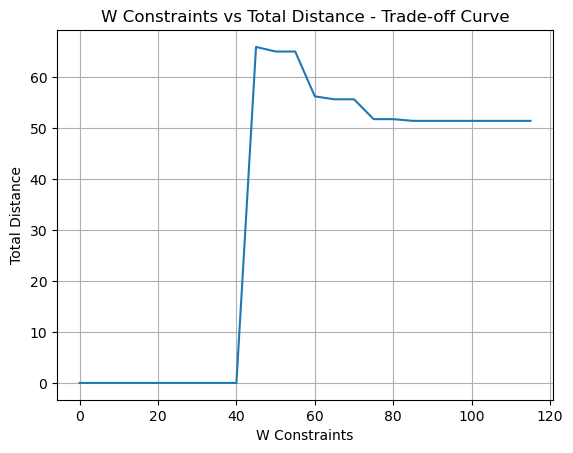

In [513]:
test_W = range(0, 120, 5)
result_dict = {}
total_distance_list = []
avg_wait_time_list = []

for w in test_W:
    result_dict[w] = one_driver_within_W(w)
    total_distance_list.append(result_dict[w]['total_distance'])
    avg_wait_time_list.append(result_dict[w]['avg_wait_time'])
    
# Plot the optimal W Value
plt.plot(test_W, total_distance_list)
plt.xlabel('W Constraints')
plt.ylabel('Total Distance')
plt.title('W Constraints vs Total Distance - Trade-off Curve')
plt.grid(True)